#Project 2
##By Niteen Kumar, Alexander Low, Kagruti Solao, Brian Weinfeld

In [5]:
from neo4j.v1 import GraphDatabase
import csv
from itertools import islice
import networkx as nx
from networkx.algorithms import bipartite as bi
import math
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
class OpenFlights(object):
    def __init__(self, uri, user, password):
        self._driver = GraphDatabase.driver(uri, auth=(user, password))

    def close(self):
        self._driver.close()

    def query(self, query):
        with self._driver.session() as session:
            return session.run(query)


Following the previous project, we decided to continue using the open flights data set. We wanted to see what actionable information we could find to aid in making money in the aviation business.

##Problem Statement
We know from the previous project that the spoke and hub model is very popular for the major airlines. However, the downside to this is that many reasonably large cities must take 2 or 3 flights to reach their destination. A number of budget airlines, Porter or Spirit for example, have found a profitable business model by identifying commonly flown routes that require multiple transfers and instead offering direct flights. 

Can we use the data set to identify any of these routes for our start up business?

In [4]:
neo = OpenFlights('bolt://localhost:7687', 'neo4j', 'password')

# neo.query('Match (n) DETACH DELETE n')
# neo.query('CREATE CONSTRAINT ON (r:Airport) ASSERT r.id IS UNIQUE')
# neo.query('CREATE CONSTRAINT ON (c:City) ASSERT c.loc IS UNIQUE')
#
# # add all cities and airports to database
# with open('openflights_airports.txt', newline='') as csvfile:
#     next(islice(csvfile, 1, 1), None)
#     for r in csv.reader(csvfile, delimiter = ' '):
#         r[1] = r[1].replace("'", "")
#         r[2] = r[2].replace("'", "")
#         r[3] = r[2] + ', ' + r[3].replace("'", "")
#         neo.query(f"MERGE (c:City {{loc: '{r[3]}' }}) ")
#         neo.query(f"MERGE (:Airport {{id: '{r[0]}', name: '{r[1]}', lat: '{r[6]}', lon: '{r[7]}'}})")
#         neo.query(f"MATCH (a:Airport {{id: '{r[0]}' }}) \
#                   WITH a \
#                   MATCH (c:City {{loc: '{r[3]}' }}) \
#                   WITH a, c \
#                   MERGE (a)-[:LOCATED {{weight: '1'}}]->(c)")
#
# #add all airports and connect to cities
# with open('openflights.txt', newline='') as csvfile:
#     for r in csv.reader(csvfile, delimiter=' '):
#         neo.query(f"MATCH (a1:Airport {{id: '{r[0]}' }}) \
#                     WITH a1 \
#                     MATCH (a2: Airport {{id: '{r[1]}' }}) \
#                     WITH a1, a2 \
#                     MATCH (a1)-[:LOCATED]->(c1:City) \
#                     WITH a1, a2, c1 \
#                     MATCH (a2)-[:LOCATED]->(c2:City) \
#                     MERGE (a1)-[:CONNECTS {{weight: '{r[2]}'}}]->(c2) \
#                     MERGE (a2)-[:CONNECTS {{weight: '{r[2]}'}}]->(c1)")

We began by splitting the data into a 2-mode set -- Airports and Cities. An airport and city node would be connected if the airport flew to, or is locted in, that particular city. The weight represents the number of airlines that connect those two cities.

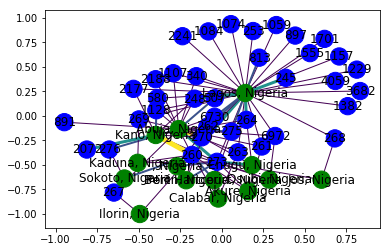

In [6]:
g = nx.Graph()

results = neo.query('MATCH (a:Airport)-[c]->(b:City),'
                    '(b)<-[]-(a2:Airport) \
                     WHERE b.loc ENDS WITH "Nigeria" \
                    AND a <> a2 \
                   RETURN a.id, b.loc, c.weight')
airports = []
cities = []

for r in results:
    if r[0] not in airports:
        airports.append(r[0])
    if r[1] not in cities:
        cities.append(r[1])
    g.add_edge(r[0], r[1], weight=r[2])
g.add_nodes_from(airports, bipartite=0)
g.add_nodes_from(cities, bipartite=1)

widths = [int(edata['weight']) for f, t, edata in g.edges(data=True)]
n_color = ['b' if x in airports else 'g' for x in g.nodes()]
pos = nx.spring_layout(g)
nx.draw_networkx(g, with_labels=True, node_color=n_color, width=widths, edge_color=widths, pos=pos)
plt.show()

In the above graph we can see the cities in Nigeria along with all the airports, identified by ID, that fly into that city. Just as we expected, even in a smaller country, they adhere to a model of one big airport and many smaller airports.

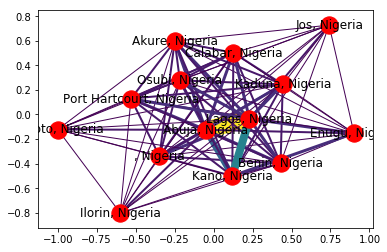

In [7]:
two = bi.weighted_projected_graph(g, cities, ratio=False)
widths = [int(edata['weight']) for f, t, edata in two.edges(data=True)]

nx.draw_networkx(two, width=widths, edge_color=widths)
plt.show()

Using a bipartite algorithm, the graph is reduced to display only cities. The connections between the two are size and color coded based on the number of airports that connect the two cities (along with those cities weights).

In [8]:
def trim_edges(g, weight=1):
    g2 = nx.Graph()
    # g2.add_nodes_from(g.nodes(data=True))
    for f, t, edata in g.edges(data=True):
        if edata['weight'] > weight:
            g2.add_edge(f, t, weight=edata['weight'])
    return g2

def island_method(g, iterations = 10):
    weights = [int(edata['weight']) for f, to, edata in g.edges(data=True)]
    mn = int(min(weights))
    mx = int(max(weights))
    step = int((mx-mn)/iterations)

    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn, mx, step)]

# islands = island_method(two)
# for i in islands:
#     print(i[0], len(i[1]), len(list(nx.connected_component_subgraphs(i[1]))))
# 
# to_disp = trim_edges(two, weight=78)
# for part in nx.connected_component_subgraphs(to_disp):
#     widths = [int(edata['weight'])/100 for f, t, edata in part.edges(data=True)]
#     nx.draw_networkx(part, width=widths, edge_color=widths)
#     plt.show()

Using two methods provided by the textbook that allows us to trim weakly connected cities, we will begin to explore the graph for cities that would company can fly between.

##Discoveries
###1: The world is incredibly well connected.

![Whole World](whole_world_1.png)

This mess represents all the tightly connected cities in the world. In short, the world is incredibly well connected. This does not leave many places for our company to run. We will need to examine on a much smaller scale. Looking at the entire planet is just too much.

At the center of this ball is London, United Kingdom, the most well connected city in the world. From London, if you are willing to get on 3 airpllanes, you can reach 2782 different cities in the world!

###2: The most tightly knit area in the world is the United Kingdom, followed by the EU.

![UK](uk_2.png)

At the center of the ball in the previous picture is London. By this measure it is the most well connected city in the world and, in a similar veign, the UK is the most well connected portion of the world.

Pulling out a bit we see that the EU is also incredibly well connected with London sitting at the center of web.

![EU](eu_3.png)

####Suggestion 1: Offer direct routes between non-UK major EU cities. 

This may include Istanbul to Madrid, Berlin to Barcelona, and so on.

###3: The United States only connects it's largest cities.

![US](us_4.png)

![US2](us_5.png)

The United States, due to it's large size, only connects it's largest cities, forcing most travelers to go through Chicago, Atlanta or New York. Comparing the first picture of only major cities to the second picture of middle sized cities offers a number of suggestions for routes.

####Suggestion 2: Middle sized cities like Seattle, Cincinnati, and Minneapolis could use direct routes to popular locations.

###4: Canada and the US have few well travelled connections.

![Canada](canada_6.png)

Expanding to include Canada only adds Toronto to the graph. This is despite the fact that our previous project demonstrated a number of large airports in major cities in Canada.

####Suggestion 3: Vancouver, Montreal, and Calgary could support routes to American destination cities.

###5: The strongest supported cities leave little room for expansion.

![Canada](canada_7.png)

The above picture shows the strongest connections in the western world. The cities on this list should be of little surprise. They form the backbone of travel in the US and Canada.

####Suggestion 4: Stay away from flights between these cities, but examine flights from these cities to less known destinations.

##Conclusion
Through examine of the bipartite data and the use of the island method of graph examination, we have been able to make 4 suggestions to our start up airline company. 

There is an existing market desire for direct connections between middle sized cities that are not big enough for the major airlines but are still large enough to support daily flights.